In [ ]:
r from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

summary_features = pd.read_csv('/content/summary_transcript_speech.csv')
#summary_features = pd.read_csv('/content/drive/My Drive/full_participant_summary.csv')

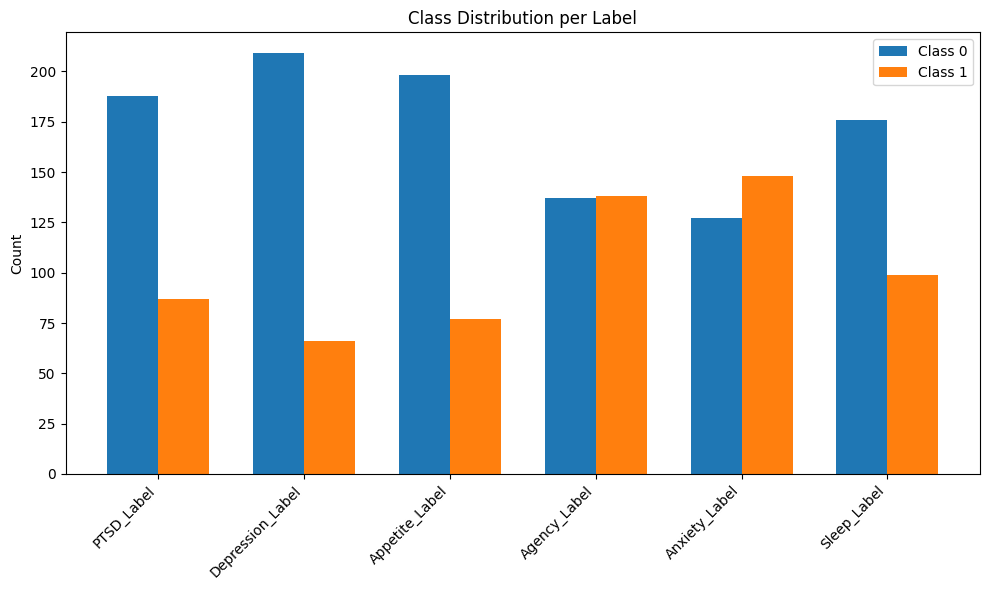

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load your label CSV
df = pd.read_csv('/content/Ground_Truth_Table.csv')

# Define labels
labels = ['PTSD_Label',	'Depression_Label',	'Appetite_Label',	'Agency_Label',	'Anxiety_Label',	'Sleep_Label']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(labels))
zeros = [df[label].value_counts().get(0, 0) for label in labels]
ones = [df[label].value_counts().get(1, 0) for label in labels]

bar_width = 0.35
ax.bar([i - bar_width/2 for i in x], zeros, width=bar_width, label='Class 0')
ax.bar([i + bar_width/2 for i in x], ones, width=bar_width, label='Class 1')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('Class Distribution per Label')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Separate features (summary_features) and the identified labels
X = summary_features
y = df[labels[1]] #i =0, 1, 2, 3, 4, 5 for diffrent targets

In [ ]:
X = summary_features.copy()

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int
discrete_features

,0
eGeMAPS_f1_mean,False
eGeMAPS_f1_std,False
eGeMAPS_f1_min,True
eGeMAPS_f1_max,False
eGeMAPS_f2_mean,False
...,...
depression_word_count,True
anxiety_word_count,True
stress_word_count,True
ptsd_word_count,True


In [ ]:
# 1) Remove columns with 100% 0 values
X = X.loc[:, (X != 0).any(axis=0)]
print(f"Shape after removing columns with 100% zeros: {X.shape}")

# Recompute discrete_features after removing columns
discrete_features = X.dtypes == int

discrete_features

Shape after removing columns with 100% zeros: (275, 643)


,0
eGeMAPS_f1_mean,False
eGeMAPS_f1_std,False
eGeMAPS_f1_max,False
eGeMAPS_f2_mean,False
eGeMAPS_f2_std,False
...,...
depression_word_count,True
anxiety_word_count,True
stress_word_count,True
ptsd_word_count,True


In [ ]:
from sklearn.feature_selection import mutual_info_classif
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores  # show a few features with their MI scores

,MI Scores
total_words,0.518931
first_person_pronoun_count,0.361072
total_utterances,0.314466
negation_count,0.069372
MFCC_f100_std,0.066875
...,...
eGeMAPS_f77_max,0.000000
eGeMAPS_f77_std,0.000000
eGeMAPS_f77_mean,0.000000
eGeMAPS_f76_max,0.000000


In [ ]:
# 2) Remove columns with MI values as 0
mi_scores = make_mi_scores(X, y, discrete_features)
columns_to_keep = mi_scores[mi_scores > 0].index
X = X[columns_to_keep]
print(f"Shape after removing columns with zero MI scores: {X.shape}")

Shape after removing columns with zero MI scores: (275, 349)


In [ ]:
# Recompute MI scores for the remaining columns
discrete_features = X.dtypes == int
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores  # show a few features with their MI scores

,MI Scores
total_words,0.518931
first_person_pronoun_count,0.361072
total_utterances,0.314466
eGeMAPS_f28_max,0.072673
negation_count,0.069372
...,...
eGeMAPS_f68_mean,0.000000
eGeMAPS_f1_max,0.000000
MFCC_f57_max,0.000000
eGeMAPS_f22_max,0.000000


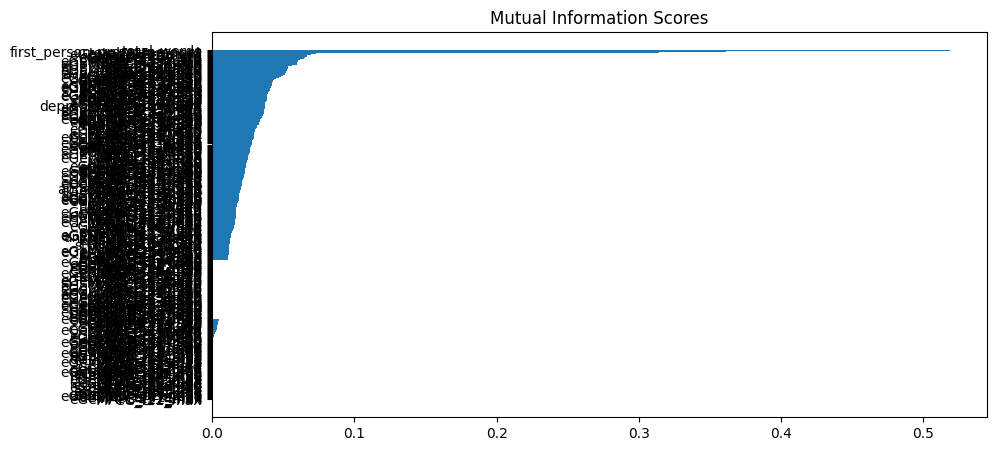

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(10, 5))
plot_mi_scores(mi_scores)

In [ ]:
# # 3) Find correlation between features and remove features with lower MI and >0.8 correlation
# correlation_matrix = X.corr().abs()
# upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# columns_to_drop_corr = set()
# for col in upper.columns:
#     for row in upper.index:
#         if upper.loc[row, col] > 0.8:
#             # Compare MI scores and mark the one with lower MI for dropping
#             if mi_scores[row] < mi_scores[col]:
#                 columns_to_drop_corr.add(row)
#             else:
#                 columns_to_drop_corr.add(col)

# X = X.drop(columns=columns_to_drop_corr)
# print(f"Shape after removing highly correlated features: {X.shape}")

# 3) Select top 20% MI valued features
mi_scores = make_mi_scores(X, y, discrete_features)
top_20_percent_features = mi_scores.head(int(len(mi_scores) * 0.2)).index
X_top_mi = X[top_20_percent_features]
print(f"Shape after selecting top 20% MI features: {X_top_mi.shape}")

Shape after selecting top 20% MI features: (275, 69)


Train & Test

In [ ]:
def plot_classification_report(all_y_true, all_y_pred):
    # Collect metrics into a long-form DataFrame for seaborn
    records = []

    for model_name in all_y_true:
        y_true = np.array(all_y_true[model_name])
        y_pred = np.array(all_y_pred[model_name])
        report = classification_report(y_true, y_pred, output_dict=True)

        for class_label, metrics in report.items():
            if class_label not in ['accuracy', 'macro avg', 'weighted avg']:
                for metric_name in ['precision', 'recall', 'f1-score']:
                    records.append({
                        'Model': model_name,
                        'Class': str(class_label),
                        'Metric': metric_name.capitalize(),
                        'Score': metrics[metric_name]
                    })

    # Convert to DataFrame
    df = pd.DataFrame(records)

    # Set the plotting style
    sns.set(style='whitegrid')
    plt.figure(figsize=(14, 6))

    # Create the bar plot
    g = sns.catplot(
        data=df,
        x='Class',
        y='Score',
        hue='Model',
        col='Metric',
        kind='bar',
        palette='tab10',
        height=6,
        aspect=1.2,
        legend_out=True
    )

    # Format axes
    g.set_titles("{col_name}")
    g.set(ylim=(0, 1.1))
    g.set_axis_labels("Class", "Score")

    # Improve layout and display
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle("Classification Metrics by Model and Class", fontsize=16)
    g.add_legend(title='Model')
    plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import numpy as np
import warnings
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore specific warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.linear_model')
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost.core')
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.svm') # Add SVM warnings

# Initialize StratifiedKFold with 5 splits
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True) # Added random_state for reproducibility

# Initialize SMOTE
smote = SMOTE()

from imblearn.over_sampling import ADASYN
adasyn = ADASYN(random_state=42) # Add random_state for reproducibility

# Dictionaries to store results and accumulated true labels and predictions
all_run_model_accuracies = {}
all_run_model_sensitivity = {}
all_run_model_specificity = {}
all_run_model_precision = {} # Added precision
all_run_model_f1 = {} # Added f1-score

all_y_true = {}
all_y_pred = {}
all_y_proba = {} # To store probabilities for PR curves

n_runs = 10


for run in range(n_runs):
    print(f"--- Run {run+1}/{n_runs} ---")
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=run) # Different random_state for each run

    for fold, (train_index, test_index) in enumerate(skf.split(X_top_mi, y)): # Use X_top_mi
        #print(f"--- Fold {fold+1}/{n_splits} ---")

        X_train, X_test = X_top_mi.iloc[train_index], X_top_mi.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Oversample the training data
        X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

        # Calculate class weights
        class_counts = y_train.value_counts()
        class_weights = {0: 1.0, 1: class_counts[0] / class_counts[1]}
        scale_pos_weight_value = class_counts[0] / class_counts[1] # For XGBoost, LightGBM, CatBoost


        # Initialize models for this fold
        models = {
            'Logistic Regression (Weighted)': LogisticRegression(max_iter=1000, class_weight=class_weights),
            'MLP Classifier (Weighted)': Sequential([
                Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
                Dense(1, activation='sigmoid')
            ]),
            'XGBoost Classifier (Weighted)': xgb.XGBClassifier(
                objective='binary:logistic',
                use_label_encoder=False,
                eval_metric='logloss',
                scale_pos_weight=scale_pos_weight_value,
                random_state=42,
                learning_rate=0.1,
                max_depth=3,
                min_child_weight=1,
                subsample=0.8,
                colsample_bytree=0.8),
            'SVM Classifier (Weighted)': SVC(kernel='rbf', probability=True, random_state=42, class_weight=class_weights),
            'Ridge Classifier (adasyn)': RidgeClassifier(random_state=42),
            'CatBoost (Weighted)': CatBoostClassifier(iterations=100, learning_rate=0.1, loss_function='Logloss', eval_metric='Accuracy', scale_pos_weight=scale_pos_weight_value, verbose=0, random_state=42),
        }

        # Train and evaluate each model
        for model_name, model in models.items():
            # Ensure model name exists in result dictionaries
            if model_name not in all_run_model_accuracies:
                all_run_model_accuracies[model_name] = []
                all_run_model_sensitivity[model_name] = []
                all_run_model_specificity[model_name] = []
                all_run_model_precision[model_name] = []
                all_run_model_f1[model_name] = []
                all_y_true[model_name] = []
                all_y_pred[model_name] = []
                all_y_proba[model_name] = []


            # Append true labels for this fold
            all_y_true[model_name].extend(y_test)

            if 'MLP' in model_name:
                # Manual class weighting for MLP
                sample_weights = np.array([class_weights[c] for c in y_train])
                model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
                model.fit(X_train, y_train.values, epochs=10, batch_size=32, verbose=0, sample_weight=sample_weights)
                y_pred_proba = model.predict(X_test).flatten()
                y_pred = (y_pred_proba > 0.5).astype(int)

            elif 'Ridge' in model_name:
                 model.fit(X_train_resampled, y_train_resampled) # Use resampled data
                 y_decision = model.decision_function(X_test)
                 # For Ridge, predict based on decision function > 0
                 y_pred = (y_decision > 0).astype(int)
                 # Ridge does not provide probabilities easily, skip proba storage for now
                 y_pred_proba = np.nan # Placeholder for non-probabilistic models


            else:
                model.fit(X_train, y_train) # Use original data with class weights
                y_pred = model.predict(X_test)
                if hasattr(model, 'predict_proba'):
                    y_pred_proba = model.predict_proba(X_test)[:, 1]
                else:
                    y_pred_proba = np.nan # Placeholder for non-probabilistic models


            accuracy = accuracy_score(y_test, y_pred)
            all_run_model_accuracies[model_name].append(accuracy)
            all_y_pred[model_name].extend(y_pred)
            if not np.isnan(y_pred_proba).all():
                 all_y_proba[model_name].extend(y_pred_proba)
            else:
                 all_y_proba[model_name].extend([np.nan] * len(y_test)) # Extend with NaN for non-probabilistic models


            report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
            # Handle cases where a class might have no predictions
            all_run_model_sensitivity[model_name].append(report.get('1', {}).get('recall', 0.0))
            all_run_model_specificity[model_name].append(report.get('0', {}).get('recall', 0.0))
            all_run_model_precision[model_name].append(report.get('1', {}).get('precision', 0.0))
            all_run_model_f1[model_name].append(report.get('1', {}).get('f1-score', 0.0))



# Print average results with standard deviation across all runs and folds
print("\n--- Average Cross-Validation Results (Across All Runs) ---")
for model_name in all_run_model_accuracies.keys():
    avg_accuracy = np.mean(all_run_model_accuracies[model_name])
    std_accuracy = np.std(all_run_model_accuracies[model_name])
    avg_sensitivity = np.mean(all_run_model_sensitivity[model_name])
    std_sensitivity = np.std(all_run_model_sensitivity[model_name])
    avg_specificity = np.mean(all_run_model_specificity[model_name])
    std_specificity = np.std(all_run_model_specificity[model_name])
    avg_precision = np.mean(all_run_model_precision[model_name])
    std_precision = np.std(all_run_model_precision[model_name])
    avg_f1 = np.mean(all_run_model_f1[model_name])
    std_f1 = np.std(all_run_model_f1[model_name])

    print(f"\n--- {model_name} ---")
    print(f"Average Accuracy = {avg_accuracy:.4f} +/- {std_accuracy:.4f}")
    print(f"Average Sensitivity = {avg_sensitivity:.4f} +/- {std_sensitivity:.4f}")
    print(f"Average Specificity = {avg_specificity:.4f} +/- {std_specificity:.4f}")
    print(f"Average Precision = {avg_precision:.4f} +/- {std_precision:.4f}")
    print(f"Average F1-score = {avg_f1:.4f} +/- {std_f1:.4f}")


# Print classification reports at the end (aggregated across all runs and folds)
print("\n--- Classification Reports (Aggregated Across All Runs and Folds) ---")
for model_name in all_y_true.keys():
    print(f"\n--- {model_name} ---")
    true_labels = np.array(all_y_true[model_name])
    predicted_labels = np.array(all_y_pred[model_name])
    print(classification_report(true_labels, predicted_labels, zero_division=0))



--- Run 1/10 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
--- Run 2/10 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
--- Run 3/10 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
--- Run 4/10 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
--- Run 5/10 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
--- Run 6/10 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import pandas as pd

# Create a dictionary to hold the average and std deviation for each metric and model
results_data = {}

for model_name in all_run_model_accuracies.keys():
    avg_accuracy = np.mean(all_run_model_accuracies[model_name])
    std_accuracy = np.std(all_run_model_accuracies[model_name])
    avg_sensitivity = np.mean(all_run_model_sensitivity[model_name])
    std_sensitivity = np.std(all_run_model_sensitivity[model_name])
    avg_specificity = np.mean(all_run_model_specificity[model_name])
    std_specificity = np.std(all_run_model_specificity[model_name])

    results_data[model_name] = {
        'Average Accuracy': f"{avg_accuracy:.4f} +/- {std_accuracy:.4f}",
        'Average Sensitivity': f"{avg_sensitivity:.4f} +/- {std_sensitivity:.4f}",
        'Average Specificity': f"{avg_specificity:.4f} +/- {std_specificity:.4f}"
    }

# Create a pandas DataFrame from the results data
results_df = pd.DataFrame.from_dict(results_data, orient='index')

# Display the DataFrame as a table
print("\n--- Average Metrics Across All Runs and Folds ---")
display(results_df)


--- Average Metrics Across All Runs and Folds ---


,Average Accuracy,Average Sensitivity,Average Specificity
Logistic Regression (Weighted),0.6025 +/- 0.0589,0.5561 +/- 0.1101,0.6242 +/- 0.0716
MLP Classifier (Weighted),0.5113 +/- 0.1119,0.4514 +/- 0.3111,0.5385 +/- 0.2842
XGBoost Classifier (Weighted),0.6804 +/- 0.0541,0.3993 +/- 0.1039,0.8108 +/- 0.0658
SVM Classifier (Weighted),0.5593 +/- 0.0983,0.2575 +/- 0.2020,0.6988 +/- 0.2243
Ridge Classifier (adasyn),0.6007 +/- 0.0612,0.5439 +/- 0.1062,0.6275 +/- 0.0805
CatBoost (Weighted),0.6891 +/- 0.0573,0.3541 +/- 0.1100,0.8442 +/- 0.0624
